In [2]:
# 📊 Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [3]:
# 📥 Step 2: Load Data
df = pd.read_csv("Global_AI_Content_Impact_Dataset.csv")
df.head()


,Country,Year,Industry,AI Adoption Rate (%),AI-Generated Content Volume (TBs per year),Job Loss Due to AI (%),Revenue Increase Due to AI (%),Human-AI Collaboration Rate (%),Top AI Tools Used,Regulation Status,Consumer Trust in AI (%),Market Share of AI Companies (%)
0,South Korea,2022,Media,44.29,33.09,16.77,46.12,74.79,Bard,Strict,40.77,18.73
1,China,2025,Legal,34.75,66.74,46.89,52.46,26.17,DALL-E,Strict,35.67,35.02
2,USA,2022,Automotive,81.06,96.13,10.66,45.60,39.66,Stable Diffusion,Moderate,54.47,22.76
3,France,2021,Legal,85.24,93.76,27.70,78.24,29.45,Claude,Moderate,51.84,1.93
4,France,2021,Gaming,78.95,45.62,17.45,1.05,21.70,Midjourney,Strict,41.77,21.41


In [4]:
# 🔍 Step 3: Data Overview
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Country                                     200 non-null    object 
 1   Year                                        200 non-null    int64  
 2   Industry                                    200 non-null    object 
 3   AI Adoption Rate (%)                        200 non-null    float64
 4   AI-Generated Content Volume (TBs per year)  200 non-null    float64
 5   Job Loss Due to AI (%)                      200 non-null    float64
 6   Revenue Increase Due to AI (%)              200 non-null    float64
 7   Human-AI Collaboration Rate (%)             200 non-null    float64
 8   Top AI Tools Used                           200 non-null    object 
 9   Regulation Status                           200 non-null    object 
 10  Consumer Trust

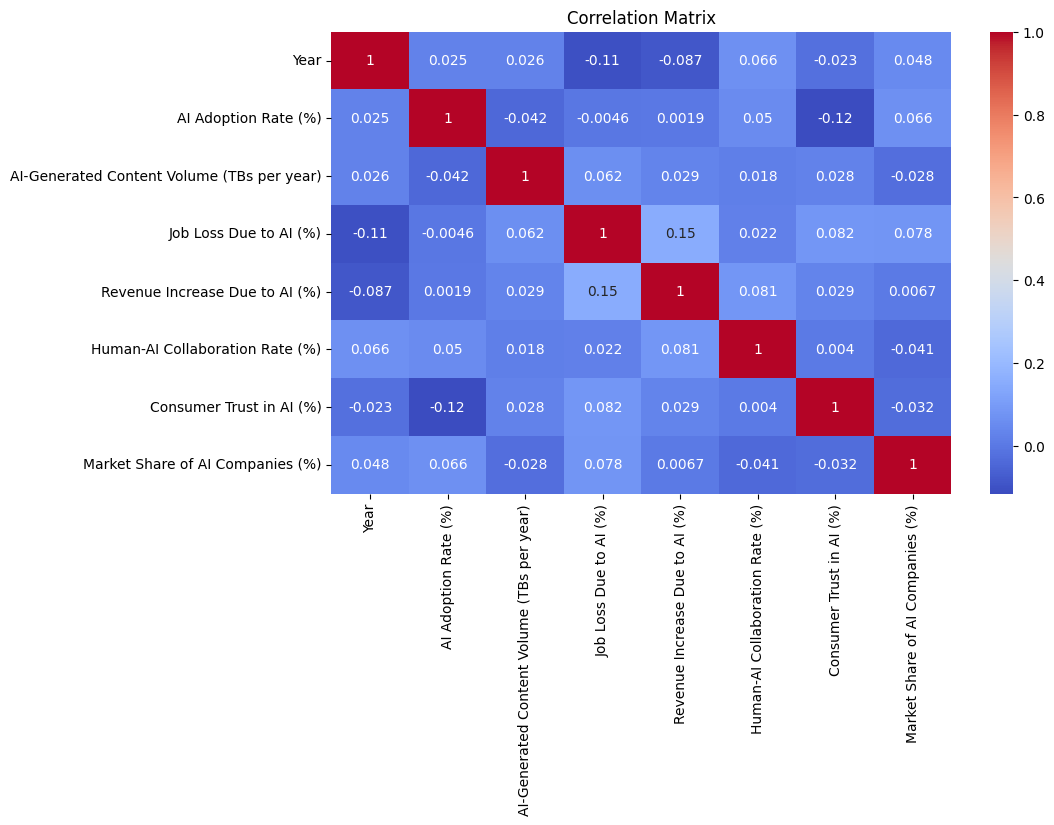

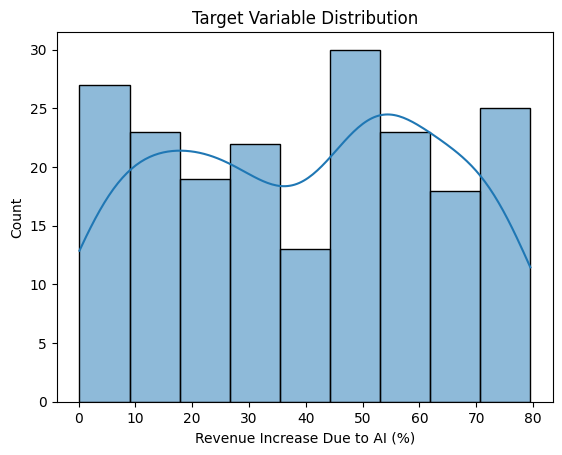

In [5]:
# 📈 Step 4: EDA
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

sns.histplot(df["Revenue Increase Due to AI (%)"], kde=True)
plt.title("Target Variable Distribution")
plt.show()


In [6]:
# 🧹 Step 5: Preprocessing
X = df.drop(columns=["Revenue Increase Due to AI (%)"])
y = df["Revenue Increase Due to AI (%)"]

categorical_features = ['Country', 'Industry', 'Top AI Tools Used', 'Regulation Status']
numerical_features = [col for col in X.columns if col not in categorical_features]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])


In [7]:
# 🎯 Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# 🤖 Step 7: Train & Evaluate Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    results[name] = {
        "R2 Score": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred)
    }

for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")



Model: Linear Regression
R2 Score: -0.3692
MAE: 24.4160
MSE: 813.9249

Model: Random Forest
R2 Score: 0.0069
MAE: 20.1270
MSE: 590.3655

Model: XGBoost
R2 Score: -0.2524
MAE: 21.8367
MSE: 744.4521


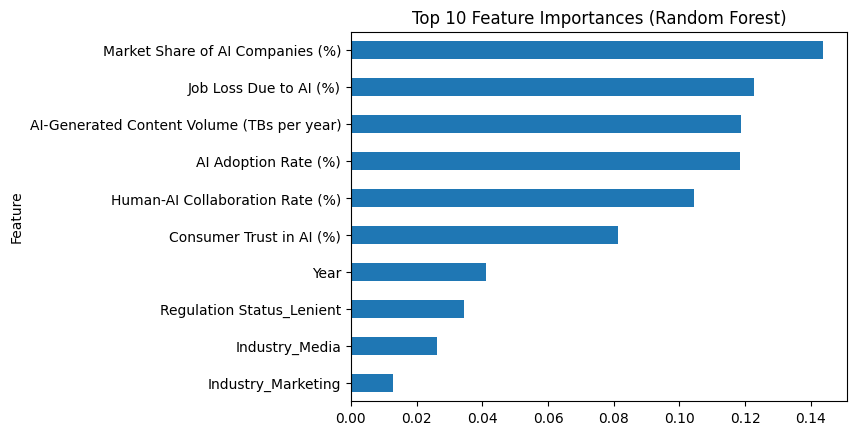

In [9]:
# 🧠 Step 8: Feature Importance (Random Forest)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", rf_model)
])
pipeline_rf.fit(X_train, y_train)

# Get feature names
feature_names = list(pipeline_rf.named_steps["preprocessor"].transformers_[0][2]) + \
    list(pipeline_rf.named_steps["preprocessor"].transformers_[1][1].named_steps["encoder"].get_feature_names_out(categorical_features))

importances = pipeline_rf.named_steps["model"].feature_importances_

importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df.sort_values(by="Importance", ascending=False).head(10).plot(
    kind="barh", x="Feature", y="Importance", legend=False)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.show()
